# 📦 Amazon Reviews Clustering Project

## 🎯 Cel biznesowy
Celem projektu jest eksploracja recenzji klientów Amazon na poziomie tekstu i wyodrębnienie naturalnych grup recenzji za pomocą metod klasteryzacji. Dzięki temu możliwe będzie uzyskanie dodatkowego wglądu w strukturę opinii użytkowników — bez konieczności wcześniejszego nadawania etykiet.

## 🗂 Dane wejściowe
Zbiór danych zawiera recenzje produktów pochodzące z platformy Amazon. Składają się one z oryginalnego tekstu recenzji, a także dodatkowych cech takich jak ocena liczbowa, klasyfikacja sentymentu czy rozkład emocji (tych na razie nie używamy — skupiamy się wyłącznie na surowym tekście z kolumny `Text`).

## ⚙️ Cel klasteryzacji
- Identyfikacja głównych grup tematycznych i tonów wypowiedzi klientów
- Zrozumienie, jak różne typy recenzji są ze sobą powiązane semantycznie
- Odkrycie nieoczywistych wzorców, np. ukrytych tematów, form językowych lub emocjonalnych tonów

## 💡 Potencjalne zastosowania
- Automatyczne przypisywanie recenzji do zespołów obsługi klienta w zależności od ich tonu lub tematyki
- Analiza niezadowolenia klientów bez potrzeby nadzorowanego etykietowania
- Wykrywanie recenzji o wysokim wpływie (np. negatywnych z konkretną argumentacją)
- Zasilenie dashboardów analitycznych segmentacją treści


In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [10]:
df = pd.read_csv("data/cleaned_amazon_reviews.csv")

df=df[["Text"]]

df.head()

,Text
0,I have bought several of the Vitality canned d...
1,Product arrived labeled as Jumbo Salted Peanut...
2,This is a confection that has been around a fe...
3,If you are looking for the secret ingredient i...
4,Great taffy at a great price. There was a wid...


In [11]:
df["Text"].isna().sum()

0

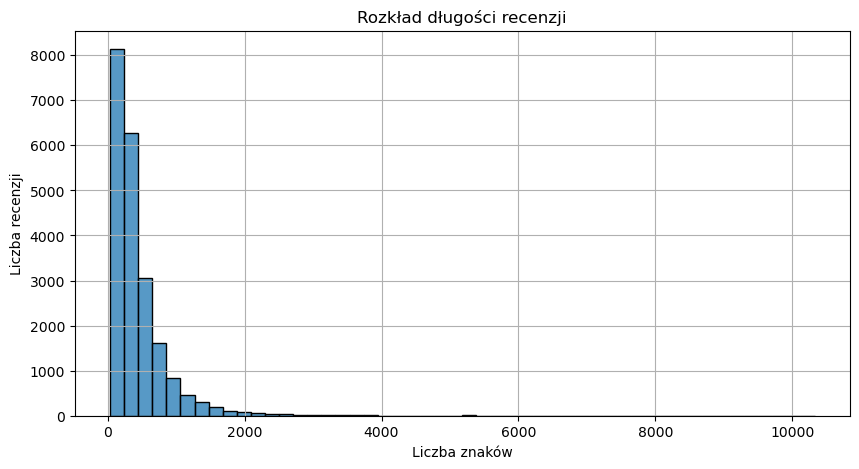

In [16]:
df["length"]=df["Text"].str.len()

plt.figure(figsize=(10,5))
sns.histplot(df["length"],bins=50,kde=False)
plt.title("Rozkład długości recenzji")
plt.xlabel("Liczba znaków")
plt.ylabel("Liczba recenzji")
plt.grid(True)
plt.show()

### Wstępne czyszczenie tekstu

Usuwamy znaki specjalne, liczby oraz zamieniamy tekst na małe litery, aby ujednolicić dane i zmniejszyć szum językowy przed dalszym przetwarzaniem.


In [18]:
def clean_text(text):
    text=text.lower()

    text = re.sub(r"\s+", " ", text).strip()

    text = re.sub(r"[^a-z\s]", "", text)

    return text


df["clean_text"]=df["Text"].apply(clean_text)

df[["Text","clean_text"]].sample(5)


,Text,clean_text
14925,My dogs LOVE this product. They beg for them. ...,my dogs love this product they beg for them th...
8206,We love anything with onions and this certainl...,we love anything with onions and this certainl...
14784,I typicaly drink Mountain Dew or more recently...,i typicaly drink mountain dew or more recently...
7229,Snappy's White Popcorn is perfect. It's hulle...,snappys white popcorn is perfect its hulless t...
15636,Very good price and excellent coffee.. Packed ...,very good price and excellent coffee packed pe...


### Detekcja języka

Sprawdzamy, w jakim języku są napisane recenzje, i zachowujemy tylko te, które są w języku angielskim.


In [56]:
from langdetect import detect
from langdetect.lang_detect_exception import LangDetectException

def detect_language(text):
    try:
        return detect(text)
    except LangDetectException:
        return "error"

df['lang'] = df['clean_text'].apply(detect_language)

print(df['lang'].value_counts())

lang
en    21218
nl        1
et        1
Name: count, dtype: int64


In [57]:
df=df[df["lang"]=="en"].reset_index(drop=True)

print(df['lang'].value_counts())

lang
en    21218
Name: count, dtype: int64


In [40]:
import spacy

# Załaduj angielski model językowy
nlp = spacy.load("en_core_web_sm")

def spacy_preprocess(text):
    doc = nlp(text)
    tokens = []
    
    for token in doc:
        if not token.is_stop and len(token.text) > 2:
            lemma=token.lemma_
            tokens.append(lemma)

    return tokens

# Stosujemy funkcję do oczyszczonych tekstów
df['tokens'] = df['clean_text'].apply(spacy_preprocess)

# Podgląd
df[['Text', 'tokens']].sample(5)


,Text,tokens
3302,My box of Grove Square Hot Cocoa arrived today...,"[box, grove, square, hot, cocoa, arrive, today..."
11884,I absolutley LOVE Gevalia coffee and was SOOOO...,"[absolutley, love, gevalia, coffee, sooooo, ha..."
18317,"I have been buying this Honey for 5 years, sin...","[buy, honey, year, lucky, find, organic, groce..."
16071,While the sugar count is slightly higher than ...,"[sugar, count, slightly, high, cocacola, soda,..."
2794,very good clam chowder.not as good as being in...,"[good, clam, chowdernot, good, maine, restaura..."


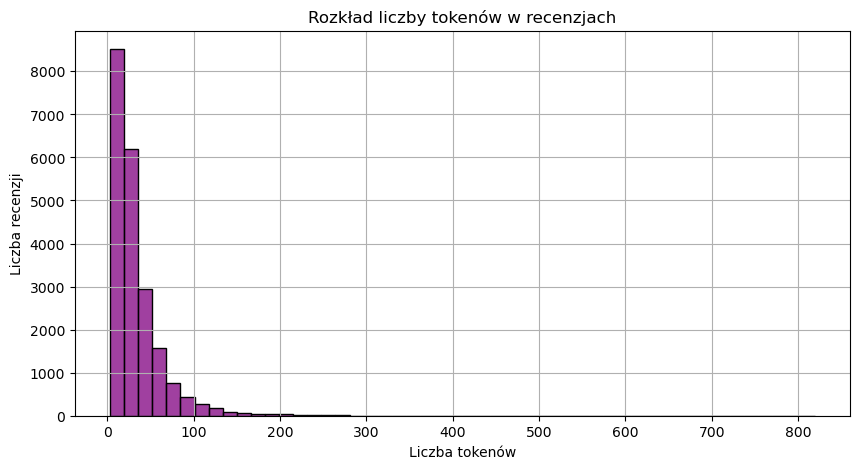

In [41]:
df['num_tokens'] = df['tokens'].apply(len)

# Wykres
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.histplot(df['num_tokens'], bins=50, color='purple')
plt.title("Rozkład liczby tokenów w recenzjach")
plt.xlabel("Liczba tokenów")
plt.ylabel("Liczba recenzji")
plt.grid(True)
plt.show()

### Filtrowanie bardzo krótkich recenzji

W ramach wstępnego oczyszczania danych zdecydowaliśmy się usunąć recenzje zawierające cztery lub mniej słów po przetworzeniu (tj. po lematyzacji i usunięciu stopwords). 

Zakładamy, że recenzje produktów na Amazonie są zawsze powiązane z oceną liczbową (np. w skali od 1 do 5). W związku z tym recenzje wyjątkowo krótkie — np. jedno- do czterowyrazowe komentarze typu „bad”, „very good product” czy „not recommended at all” — nie wnoszą istotnej informacji semantycznej ponad to, co już zawiera liczba gwiazdek. 

Usunięcie tych recenzji pozwala skupić się na danych zawierających treści o wyższej wartości informacyjnej, co jest istotne w kontekście dalszej analizy tematycznej i klasteryzacji.

In [60]:
print(f"Liczba recenzji przed filtrem: {len(df)}")

df=df[df["tokens"].apply(lambda x: len(x)>= 5)].reset_index(drop=True)

df['processed_text'] = df['tokens'].apply(lambda tokens: ' '.join(tokens))

print(f"Liczba recenzji po filtrze: {len(df)}")
df[['tokens', 'processed_text']].head()

Liczba recenzji przed filtrem: 21218
Liczba recenzji po filtrze: 21218


,tokens,processed_text
0,"[buy, vitality, can, dog, food, product, find,...",buy vitality can dog food product find good qu...
1,"[product, arrived, label, jumbo, salt, peanuts...",product arrived label jumbo salt peanutsthe pe...
2,"[confection, century, light, pillowy, citrus, ...",confection century light pillowy citrus gelati...
3,"[look, secret, ingredient, robitussin, believe...",look secret ingredient robitussin believe find...
4,"[great, taffy, great, price, wide, assortment,...",great taffy great price wide assortment yummy ...


### Analiza sentymentu za pomocą VADER

Do oceny emocjonalnego wydźwięku recenzji wykorzystujemy narzędzie VADER (Valence Aware Dictionary and sEntiment Reasoner), które jest dostosowane do analizy krótkich tekstów, takich jak opinie internetowe. 

VADER uwzględnia m.in. wielkie litery, wykrzykniki, słowa nacechowane emocjonalnie i potrafi wychwytywać subtelności sentymentu. Dla każdej recenzji wyznaczamy:
- **compound** – ogólny poziom sentymentu (w skali od –1 do 1),
- **pos / neu / neg** – udział pozytywnych, neutralnych i negatywnych słów.

Analiza ta pozwoli nam później lepiej zrozumieć strukturę emocjonalną recenzji oraz potencjalne różnice między klastrami.


In [61]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

def get_vader_sentiment(text):
    scores = analyzer.polarity_scores(text)
    return pd.Series({
        'vader_compound': scores['compound'],
        'vader_pos': scores['pos'],
        'vader_neu': scores['neu'],
        'vader_neg': scores['neg']
    })

df_vader = df['Text'].apply(get_vader_sentiment)
df = pd.concat([df, df_vader], axis=1)


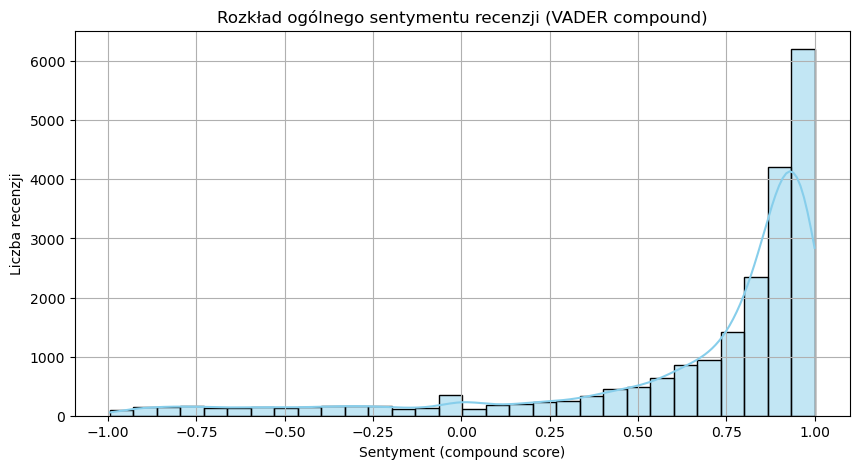

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.histplot(df['vader_compound'], bins=30, kde=True, color='skyblue')

plt.title("Rozkład ogólnego sentymentu recenzji (VADER compound)")
plt.xlabel("Sentyment (compound score)")
plt.ylabel("Liczba recenzji")
plt.grid(True)
plt.show()


### Wniosek z analizy sentymentu

Rozkład wartości `compound` uzyskanych z analizatora VADER pokazuje wyraźną dominację recenzji o pozytywnym wydźwięku. Większość opinii skupia się w przedziale bliskim wartości 1.0, co oznacza, że użytkownicy Amazona najczęściej wystawiają recenzje nacechowane pozytywnie.
